## Download the Dataset and Glove Embeddings

In [ ]:
!wget http://saifmohammad.com/WebDocs/EmoInt%20Train%20Data/sadness-ratings-0to1.train.txt
!wget http://saifmohammad.com/WebDocs/EmoInt%20Train%20Data/anger-ratings-0to1.train.txt
!wget http://saifmohammad.com/WebDocs/EmoInt%20Train%20Data/fear-ratings-0to1.train.txt
!wget http://saifmohammad.com/WebDocs/EmoInt%20Train%20Data/joy-ratings-0to1.train.txt

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip /content/glove.6B.zip

## Import Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

## Load and Prepocess the Dataset

In [4]:
Joy = open("/content/joy-ratings-0to1.train.txt", "r+")
Joy = Joy.read()

Fear = open("/content/fear-ratings-0to1.train.txt", "r+")
Fear = Fear.read()

Anger = open("/content/anger-ratings-0to1.train.txt", "r+")
Anger = Anger.read()

Sadness = open("/content/sadness-ratings-0to1.train.txt", "r+")
Sadness = Sadness.read()

In [5]:
def preprocessing(File):
  X = []
  Y = []
  List = list(File.split("\n"))
  for i in range(len(List)):
    try:
      List[i] = list(List[i].split("\t"))
      if float(List[i][3]) >= 0.4:
        X.append(List[i][1])
        if List[i][2] == 'joy':
          Y.append(0)
        elif List[i][2] == 'fear':
          Y.append(1)
        elif List[i][2] == 'anger':
          Y.append(2)
        elif List[i][2] == 'sadness':
          Y.append(3)
      elif float(List[i][3]) >= 0.2:
        X.append(List[i][1])
        Y.append(4)
    except:
      pass
  
  return X, Y

In [6]:
class_names = {0: 'joy', 1: 'fear', 2: 'anger', 3: 'sadness', 4: 'neutral'}

In [7]:
X_Joy, Y_Joy = preprocessing(Joy)
X_Fear, Y_Fear = preprocessing(Fear)
X_Anger, Y_Anger = preprocessing(Anger)
X_Sadness, Y_Sadness = preprocessing(Sadness)

In [8]:
X = []
Y = []

X = X_Joy + X_Fear + X_Anger + X_Sadness
Y = Y_Joy + Y_Fear + Y_Anger + Y_Sadness

In [9]:
embeddings = open("/content/glove.6B.200d.txt")

In [10]:
embeddings_index = {}
for line in embeddings:
  word, coefs = line.split(maxsplit = 1)
  coefs = np.fromstring(coefs, "f", sep = " ")
  embeddings_index[word] = coefs

In [11]:
MAX_LENGTH = 200
vectorizer = TextVectorization(max_tokens = 20000, output_sequence_length = MAX_LENGTH)
vectorizer.adapt(X)

In [12]:
vocablary = vectorizer.get_vocabulary()
word_index = dict(zip(vocablary, range(len(vocablary))))

Build Weight Matrix

In [13]:
num_tokens = len(vocablary) + 2
EMBEDDING_DIM = 200
hits = 0
misses = 0

weight_matrix = np.zeros((num_tokens, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        weight_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 6962 words (3422 misses)


In [14]:
X = vectorizer(np.array([[s] for s in X])).numpy()
Y = np.array(Y)

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

## Build the Model using Subclassing API of TensorFlow

In [16]:
class Model(tf.keras.Model):
  
  def __init__(self, weight_matrix, EMBEDDING_DIM, MAX_LENGTH):
    super(Model, self).__init__()
    self.Embedding = tf.keras.layers.Embedding(input_dim = len(weight_matrix),
                                               output_dim = EMBEDDING_DIM,
                                               embeddings_initializer = tf.keras.initializers.Constant(weight_matrix),
                                               trainable = False,
                                               input_length = MAX_LENGTH)
    self.Bidirectional = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout = 0.2, recurrent_dropout = 0.2))
    self.Dense = tf.keras.layers.Dense(512, activation = 'relu')
    self.Dropout = tf.keras.layers.Dropout(0.5)
    self.Output = tf.keras.layers.Dense(5, activation = 'softmax')
  
  def call(self, inputs):
    x = self.Embedding(inputs)
    x = self.Bidirectional(x)
    x = self.Dense(x)
    x = self.Dropout(x)
    x = self.Output(x)
    return x

In [17]:
model = Model(weight_matrix, EMBEDDING_DIM, MAX_LENGTH)

In [18]:
model.compile(optimizer = 'adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics = ['accuracy'])

In [19]:
history = model.fit(X_train, Y_train, epochs = 10, validation_data = (X_test, Y_test), batch_size = 32)

Epoch 1/10
86/86 [==============================] - 105s 1s/step - loss: 1.5472 - accuracy: 0.3050 - val_loss: 1.3282 - val_accuracy: 0.4217
Epoch 2/10
86/86 [==============================] - 101s 1s/step - loss: 1.2521 - accuracy: 0.4631 - val_loss: 1.2490 - val_accuracy: 0.4729
Epoch 3/10
86/86 [==============================] - 95s 1s/step - loss: 1.1026 - accuracy: 0.5464 - val_loss: 1.0529 - val_accuracy: 0.5842
Epoch 4/10
86/86 [==============================] - 95s 1s/step - loss: 0.9473 - accuracy: 0.6154 - val_loss: 1.0031 - val_accuracy: 0.5900
Epoch 5/10
86/86 [==============================] - 96s 1s/step - loss: 0.7860 - accuracy: 0.6903 - val_loss: 0.9672 - val_accuracy: 0.6164
Epoch 6/10
86/86 [==============================] - 94s 1s/step - loss: 0.6980 - accuracy: 0.7323 - val_loss: 0.9578 - val_accuracy: 0.6237
Epoch 7/10
86/86 [==============================] - 95s 1s/step - loss: 0.6499 - accuracy: 0.7409 - val_loss: 0.9831 - val_accuracy: 0.6252
Epoch 8/10
86/86 [

## Create a plot of accuracy and loss over time

In [20]:
history_dict = history.history

loss = history_dict["loss"]
accuracy = history_dict["accuracy"]
val_loss = history_dict["val_loss"]
val_accuracy = history_dict["val_accuracy"]

epochs = range(1, len(loss) + 1)

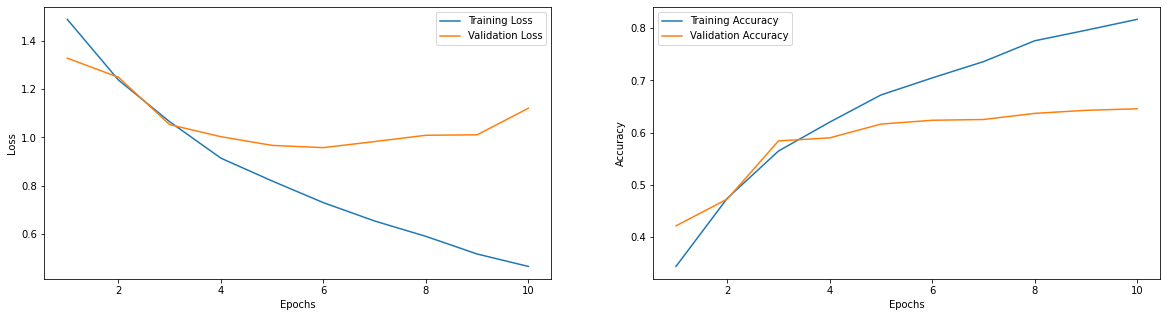

In [21]:
plt.figure(figsize = (20, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label = "Training Loss")
plt.plot(epochs, val_loss, label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, label = "Training Accuracy")
plt.plot(epochs, val_accuracy, label = "Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

## Make Predictions

In [22]:
def prediction(sentence, class_names):
  prediction = vectorizer(np.array([[s] for s in sentence])).numpy()
  prediction = model.predict(prediction)
  prediction = np.argmax(prediction, axis = 1).tolist()
  for i in range(len(prediction)):
    prediction[i] = class_names[prediction[i]]
  return prediction

In [23]:
Test = ['this is such an amazing movie!',
        'The movie was meh.',
        'The movie was okish.',
        'The movie was terrible...',
        'Be at the end of your rope',
        'Pumped up',
        'Afraid of your own shadow',
        'Black mood']

prediction = prediction(Test, class_names)
print(prediction)

['joy', 'neutral', 'neutral', 'fear', 'neutral', 'neutral', 'fear', 'sadness']
